<a href="https://colab.research.google.com/github/PremaKathiresanVasagam/TSAI---EVA5/blob/master/SessionS11/S11_NewResnet_without_Modularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My\ Drive/EVA5/Session 9/

[Errno 2] No such file or directory: 'drive/My Drive/EVA5/Session 9/'
/content/drive/My Drive/EVA5


In [11]:
# Importing torch packages for Neural Network building
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.PrepLayer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

#Layer 1
    self.x1 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, bias=False),
        nn.MaxPool2d(2, 2),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )

    self.R1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU()
            )

#Layer2
    self.Layer2 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, bias=False),
        nn.MaxPool2d(2, 2),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )


#Layer 3
    self.x2 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, bias=False),
        nn.MaxPool2d(2, 2),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )

    self.R2 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False), 
        nn.BatchNorm2d(512),
        nn.ReLU(),
        
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )

#MaxPool Layer
    self.MaxPool = nn.MaxPool2d(4,4)

#Fully Connected
    self.FC= nn.Linear(in_features = 512, out_features = 10, bias=False)
 

  def forward(self, x):
    PrepLayer = self.PrepLayer(x)
    x1 = self.x1(PrepLayer)
    R1 = self.R1(x1)
    Layer1=R1+x1
    Layer2=self.Layer2(Layer1)
    x2=self.x2(Layer2)
    R2=self.R2(x2)
    Layer3=x2+R2
    Pool=self.MaxPool(Layer3)
    Pool=Pool.view(Pool.size(0),-1)
    fc=self.FC(Pool)

    return F.log_softmax(fc)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:

torch.manual_seed(1)
batch_size = 512

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                    transform=transforms.Compose([
                                      #A.PadIfNeeded(min_height=36, min_width=36, border_mode = cv2.BORDER_REFLECT, always_apply=True,),
                                      #A.RandomCrop(height=32, width=32, always_apply=True),
                                      #A.HorizontalFlip(p = 0.7),
                                      #A.Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784)),
                                      #A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=0.7),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)



Files already downloaded and verified


In [ ]:

torch.manual_seed(1)
batch_size = 512

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                    transform=A.Compose([
                                      A.PadIfNeeded(min_height=36, min_width=36, border_mode = cv2.BORDER_REFLECT, always_apply=True,),
                                      A.RandomCrop(height=32, width=32, always_apply=True),
                                      A.HorizontalFlip(p = 0.7),
                                      A.Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784)),
                                      A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=0.7),
                                      transforms.ToTensor(),
                                      #transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=A.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)



Files already downloaded and verified


In [ ]:
import copy

Lrtest_train_acc = []
LRtest_Lr = []
def LR_test(max_lr, min_lr,device,epoch,model,criterion,train_loader,momemtum = 0.9,weight_decay=0.05, plot= True ):
    #print("2")
    step = (max_lr - min_lr )/epoch
    lr = min_lr
    for e in range(epoch):
        testmodel = copy.deepcopy(model)
        optimizer = optim.SGD(testmodel.parameters(), lr=lr ,momentum=momemtum,weight_decay=weight_decay ) 
        lr += (max_lr - min_lr)/epoch
        testmodel.train()
        #print(train_loader)
        pbar = tqdm(train_loader)
        correct = 0
        processed = 0
        #print("3")
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            y_pred =testmodel(data)
            loss = criterion(y_pred, target)
            loss.backward()
            optimizer.step()
            pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)
            pbar.set_description(desc= f'epoch = {e+1} Lr = {optimizer.param_groups[0]["lr"]}  Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        Lrtest_train_acc.append(100*correct/processed)
        LRtest_Lr.append(optimizer.param_groups[0]['lr'])

    if(plot):
        plt.plot(LRtest_Lr, Lrtest_train_acc)
        plt.ylabel('train Accuracy')
        plt.xlabel("Learning rate")
        plt.title("Lr v/s accuracy")
        plt.show()



  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.

epoch = 1 Lr = 0.001  Loss=2.768798828125 Batch_id=0 Accuracy=12.89:   0%|          | 0/98 [00:00<?, ?it/s]
epoch = 1 Lr = 0.001  Loss=2.768798828125 Batch_id=0 Accuracy=12.89:   1%|          | 1/98 [00:00<00:56,  1.72it/s]
epoch = 1 Lr = 0.001  Loss=2.6088931560516357 Batch_id=1 Accuracy=12.11:   1%|          | 1/98 [00:00<00:56,  1.72it/s]
epoch = 1 Lr = 0.001  Loss=2.6088931560516357 Batch_id=1 Accuracy=12.11:   2%|▏         | 2/98 [00:00<00:45,  2.09it/s]
epoch = 1 Lr = 0.001  Loss=2.4255051612854004 Batch_id=2 Accuracy=12.17:   2%|▏         | 2/98 [00:01<00:45,  2.09it/s]
epoch = 1 Lr = 0.001  Loss=2.4255051612854004 Batch_id=2 Accuracy=12.17:   3%|▎         | 3/98 [00:01<00:38,  2.47it/s]
epoch = 1 Lr = 0.001  Loss=2.3633170127868652 Batch_id=3 Accuracy=

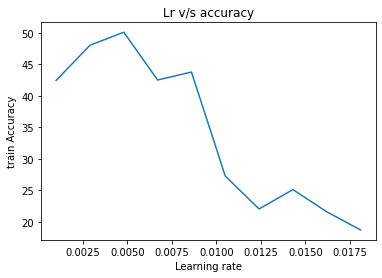

In [ ]:
#import torch.nn as nn
max_lr = 0.02
min_lr = 0.001
epoch = 10
criterion = nn.NLLLoss()
#print("1")
LR_test(max_lr, min_lr,device,epoch,model,criterion,train_loader,momemtum = 0.9,weight_decay=0.05, plot= True )

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay=0.005 ) 
criterion = nn.NLLLoss()
scheduler = OneCycleLR(optimizer, max_lr = 0.0125, total_steps=None, epochs=24, steps_per_epoch=1, pct_start=0.25, anneal_strategy='linear', 
                       cycle_momentum=False, base_momentum=0.8, max_momentum=0.9, div_factor=10.0,final_div_factor =1)

In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
test_loss = []
test_acc = []
train_loss = []
train_acc = []
LR = []

def train_model(model,device,trainloader,testloader,optimizer,criterion,EPOCHS,scheduler,batch_scheduler = False ,best_acc = 0,path = "/content/gdrive/My Drive/school_of_ai/chap11/bestmodel.pt"):
  train_scheduler = False

  for epoch in range(EPOCHS):
      print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
      LR.append(optimizer.param_groups[0]['lr'])
      if(batch_scheduler):
        train_scheduler = scheduler
      train_loss, train_acc = train(model, device, trainloader, optimizer, criterion, epoch,train_scheduler)
      if(not batch_scheduler): 
        scheduler.step()
      test_loss , test_acc = test(model, device, criterion, testloader)
      
      
      if(test_acc[-1]>best_acc):
        print("accuracy increased, Saving model....")
        best_acc = test_acc[-1]
        torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': test_loss[-1],
              }, path)

In [ ]:
train_model(model,device,trainloader,testloader,optimizer,criterion,24,scheduler,best_acc = 0,path = "/content/gdrive/My Drive/school_of_ai/chap11/bestmodel.pt")

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 25):
    print(epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0654, Accuracy: 9800/10000 (98.00%)

2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9890/10000 (98.90%)

3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9894/10000 (98.94%)

4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9911/10000 (99.11%)

5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9915/10000 (99.15%)

6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9911/10000 (99.11%)

7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9909/10000 (99.09%)

8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)

9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9933/10000 (99.33%)

10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9909/10000 (99.09%)

11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9933/10000 (99.33%)

12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9929/10000 (99.29%)

13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9939/10000 (99.39%)

15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9932/10000 (99.32%)

16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9944/10000 (99.44%)

18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9926/10000 (99.26%)

19


loss=0.009221390821039677 batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 33.49it/s]



Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99.33%)



In [ ]:
train_model(model,device,trainloader,testloader,optimizer,criterion,24,scheduler,best_acc = 0,path = "/content/gdrive/My Drive/school_of_ai/chap11/bestmodel.pt")